# Telecom prepaid plans analysis

The telecom operator Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
There's a small dataset for 500 clients of Megaline and their usage during 2018.

The purpose of the study: to find out what is the revenue from each customer per month, determine which plan brings in more revenue in order to adjust the advertising budget, and investigate additional hypothesis about the castumers.


**Project Steps** <a class="anchor" id="table_of_contents"></a>  
[Data file and general info](#chapter1)  
[Data preprocessing](#chapter2)  
[Exploratory Data Analysis](#chapter3)  
[Statistical Data Analysis](#chapter4)  
[Overall conclusion](#chapter5)  

## 1. Data file and general info
<a class="anchor" id="chapter1"></a>

In [1]:
#import libraries of functions
! pip install plotly --upgrade
! pip install -U kaleido
import pandas as pd
import datetime as dt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as st

#load the data file on the platform,as well as on my local computer.
try:
    df_calls = pd.read_csv('megaline_calls.csv')
    df_internet = pd.read_csv('megaline_internet.csv')
    df_msg = pd.read_csv('megaline_messages.csv')
    df_plans = pd.read_csv('megaline_plans.csv')
    df_users = pd.read_csv('megaline_users.csv')
    
except:
    df_calls = pd.read_csv('/datasets/megaline_calls.csv')
    df_internet = pd.read_csv('/datasets/megaline_internet.csv')
    df_msg = pd.read_csv('/datasets/megaline_messages.csv')
    df_plans = pd.read_csv('/datasets/megaline_plans.csv')
    df_users = pd.read_csv('/datasets/megaline_users.csv')

Requirement already up-to-date: plotly in c:\users\yudit\anaconda3\lib\site-packages (5.6.0)


Let's first take a closer look at the whole dataset.

In [2]:
#dictionery for iterations
dfs = {
    "df_calls" : df_calls,
    "df_internet" : df_internet,
    "df_msg" : df_msg,
    "df_users" : df_users,
    "df_plans" : df_plans
}

#show the first rows of the data 
for k,v in dfs.items():
    print('\n{}\n{}'.format(k, v.head()))


df_calls
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

df_internet
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

df_msg
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

df_users
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   

In [3]:
#show the first rows of the data 
for k,v in dfs.items():
    print('\n{}\n{}\n'.format(v.info(),v.describe()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

None
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user

- All `user_id` columns should be converted to 'object' type.
- All columns containing dates should be converted to 'datetime' type.
- The `duration` column in the calls data frame is of float type but we know that at Megaline each individual call is rounded up, so we'll round it up and save it as int type.
- There are 34 out of 500 users that stopped using the service.
- There are call durations of 0.0 minutes, probablly missed calls, we need to decide how to deal with them.

## 2. Data Preprocessing
<a class="anchor" id="chapter2"></a>

In [4]:
#creat a copy of the data so it could be manipulated without affecting the original data
for k,v in dfs.items():
    name = k + '_original'
    name = v.copy(deep=True)

### Processing missing values

Check the % of calls where the duration is 0.0 minutes

In [5]:
#determine how many calls have 0.0 minutes duration
df_calls[df_calls['duration'] == 0]['duration'].count()/len(df_calls) * 100

19.482339274694162

In [6]:
#determine how many sessions have 0.0 mb_usage
df_internet[df_internet['mb_used'] == 0]['mb_used'].count()/len(df_internet) * 100

13.11423801574052

It make sense that 1 out of 5 calls is not answerd. We could estimate the revenue **if those calls were answered** by calculating the mean duration of a call for a particular user but for this report we can remove those records as they didn't actually affected the revenue. For sessions that use 0 mb we can assume that there were a poor internet infrastructure that might interupt the session, or it was a very short session. Also these values don't contibute much to our analysis so we will remove them.

In [7]:
#remove those records
df_calls.drop(df_calls[df_calls['duration'] == 0].index, inplace=True)
df_internet.drop(df_internet[df_internet['mb_used'] == 0].index, inplace=True)
#check if changed
display(df_calls[df_calls['duration'] == 0]['duration'].count()/len(df_calls) * 100,
df_internet[df_internet['mb_used'] == 0]['mb_used'].count()/len(df_internet) * 100)

0.0

0.0

We will leave the NaN values at the `churn_date` column unchanged because we don't need them for our calculations. For other future purpose we can change them to a date in the future.

### Changing Data Types

As we mentioned, we need to convert the columns containing dates to 'datetime' type. The `user_id` columns into 'object' type and to round up the `duration` column and convert it to 'int' type. We will start with the last one.

In [8]:
#round up and convert to int
df_calls['duration'] = np.ceil(df_calls['duration']).astype('int')
#check if changed
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


Now chnge the type of `user_id` columns to 'object' and columns containing dates to 'datetime'

In [9]:
#for all the user_id columns change the type to object
for k,v in dfs.items():
    columns = v.columns
    for name in columns:
        if name == 'user_id':
            v[name] = v[name].astype('str')

In [10]:
#change the type to datetime for all the dates columns
for k,v in dfs.items():
    columns = v.columns
    for name in columns:
        if 'date' in name:
            v[name] = pd.to_datetime(v[name], format='%Y-%m-%d')

#check if changed
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


Now the data is ready for merging between the datasets for our analysis.

### Dealing With Duplicates

In [11]:
df_users[df_users['user_id'].duplicated()].count()

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

There's no duplicity in user ids, we can continue. We creat a new dataframe that summarize all the data for every user per month - the total duration of calls, total number of messages sent and total mb usage of internet, rounded up to GB. First we will add a column in each dataset of the month the action occured.

In [12]:
#add a column 'month' for the month the action occured
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_msg['month'] = pd.DatetimeIndex(df_msg['message_date']).month

Now we sum the calls of every user, grouped by the month

data_frames = [data_group, call_group, mess_group]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_frames)

In [13]:
#creat a pivot for the sum of calls for every user in every month
user_summary = df_calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc='sum').reset_index()
user_summary

,user_id,month,duration
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2251,1498,12,339
2252,1499,9,346
2253,1499,10,385
2254,1499,11,308


Now we add a column that conatains the number of messages each user sent in every month

In [14]:
#count the number of messages sent by every user in every month
messages = df_msg.pivot_table(index = ['user_id','month'], values='message_date', aggfunc='count')
#add the column to the summary table
user_summary = user_summary.merge(messages, on = ['user_id','month'], how='outer')
user_summary

,user_id,month,duration,message_date
0,1000,12,124.0,11.0
1,1001,8,182.0,30.0
2,1001,9,315.0,44.0
3,1001,10,393.0,53.0
4,1001,11,426.0,36.0
...,...,...,...,...
2285,1349,11,NaN,72.0
2286,1349,12,NaN,61.0
2287,1361,5,NaN,2.0
2288,1407,11,NaN,1.0


Now we add a column that conatains the monthly mb usage of each user in each month

In [15]:
#sum the mb usage for each user in every month
internet_usage = df_internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc='sum')
#add the column to the summary table
user_summary = user_summary.merge(internet_usage, on = ['user_id','month'], how='outer')
user_summary

,user_id,month,duration,message_date,mb_used
0,1000,12,124.0,11.0,1901.47
1,1001,8,182.0,30.0,6919.15
2,1001,9,315.0,44.0,13314.82
3,1001,10,393.0,53.0,22330.49
4,1001,11,426.0,36.0,18504.30
...,...,...,...,...,...
2288,1407,11,NaN,1.0,290.06
2289,1482,10,NaN,2.0,NaN
2290,1094,10,NaN,NaN,1728.71
2291,1108,12,NaN,NaN,233.17


For the data to be more clear and easy for understanding and analyzing we'll change the columns names. Then we'll add for each user his/her plan. There are some people that doesn't use one or more of the services. In such cases we'll fill the missing values with 0 so it won't affect the total revenue.

In [16]:
#change the columns names
user_summary.columns = ['user_id','month','minutes', 'messages', 'mb_per_month']
user_summary

,user_id,month,minutes,messages,mb_per_month
0,1000,12,124.0,11.0,1901.47
1,1001,8,182.0,30.0,6919.15
2,1001,9,315.0,44.0,13314.82
3,1001,10,393.0,53.0,22330.49
4,1001,11,426.0,36.0,18504.30
...,...,...,...,...,...
2288,1407,11,NaN,1.0,290.06
2289,1482,10,NaN,2.0,NaN
2290,1094,10,NaN,NaN,1728.71
2291,1108,12,NaN,NaN,233.17


In [17]:
#show the plan of each user
plans = df_users[['user_id','plan']]
#add the plan to the summary table
user_summary = user_summary.merge(plans, on = 'user_id').fillna(0)
user_summary

,user_id,month,minutes,messages,mb_per_month,plan
0,1000,12,124.0,11.0,1901.47,ultimate
1,1001,8,182.0,30.0,6919.15,surf
2,1001,9,315.0,44.0,13314.82,surf
3,1001,10,393.0,53.0,22330.49,surf
4,1001,11,426.0,36.0,18504.30,surf
...,...,...,...,...,...,...
2288,1204,12,0.0,78.0,36730.05,ultimate
2289,1349,10,0.0,76.0,13093.55,surf
2290,1349,11,0.0,72.0,17128.26,surf
2291,1349,12,0.0,61.0,13039.91,surf


Now that everything is ready for our calculations, we'll add the total revenue of each user on each month, depending on the plan.

In [18]:
#function fo calculating the total revenue, based on the plans terms
def total_revenue(row):
    plan = row['plan']
    #start with the montly fee
    total_revenue = int(df_plans[df_plans['plan_name'] == plan]['usd_monthly_pay'])
    
    #calculate the exceeding minutes
    if row['minutes'] > int(df_plans[df_plans['plan_name'] == plan]['minutes_included']):
        exceed_calls = row['minutes'] - int(df_plans[df_plans['plan_name'] == plan]['minutes_included'])
        total_revenue += exceed_calls*float(df_plans[df_plans['plan_name'] == plan]['usd_per_minute'])
        
    #calculate the exceeding messages
    if row['messages'] > int(df_plans[df_plans['plan_name'] == plan]['messages_included']):
        exceed_msg = row['messages'] - int(df_plans[df_plans['plan_name'] == plan]['messages_included'])
        total_revenue += exceed_msg*float(df_plans[df_plans['plan_name'] == plan]['usd_per_message'])
        
    #calculate the exceeding mb usage
    if row['mb_per_month'] > int(df_plans[df_plans['plan_name'] == plan]['mb_per_month_included']):
        exceed_mb = row['mb_per_month'] - int(df_plans[df_plans['plan_name'] == plan]['mb_per_month_included']) 
        total_revenue += (np.ceil(exceed_mb/1024))*float(df_plans[df_plans['plan_name'] == plan]['usd_per_gb'])
        
    return total_revenue


user_summary['revenue'] = user_summary.apply(total_revenue,axis = 1)
user_summary

,user_id,month,minutes,messages,mb_per_month,plan,revenue
0,1000,12,124.0,11.0,1901.47,ultimate,70.00
1,1001,8,182.0,30.0,6919.15,surf,20.00
2,1001,9,315.0,44.0,13314.82,surf,20.00
3,1001,10,393.0,53.0,22330.49,surf,90.09
4,1001,11,426.0,36.0,18504.30,surf,60.00
...,...,...,...,...,...,...,...
2288,1204,12,0.0,78.0,36730.05,ultimate,112.00
2289,1349,10,0.0,76.0,13093.55,surf,20.78
2290,1349,11,0.0,72.0,17128.26,surf,40.66
2291,1349,12,0.0,61.0,13039.91,surf,20.33


In [19]:
user_summary.sample(5)

,user_id,month,minutes,messages,mb_per_month,plan,revenue
1006,1215,11,699.0,92.0,35029.93,surf,227.23
1245,1268,3,307.0,10.0,19992.19,surf,70.00
503,1109,6,572.0,0.0,12202.07,surf,22.16
832,1178,11,405.0,48.0,18044.83,surf,50.00
1620,1358,7,369.0,3.0,18422.08,surf,50.00


Now we have all the needed data for the analysis!

## 3. Exploratory Data Analysis
<a class="anchor" id="chapter3"></a>

Now we will analayz the customers' behavior. We'll show the totals of minutes, texts, and volume of data the users of each plan require per month. We'll calculate the mean, variance and standard deviation and define outliers. We'll clean the data and show the histograms of the relevant values.
First we will group the table by plans and months.

In [20]:
#creat a pivot table grouped by plan and months
mean_per_month = (
    user_summary
    .pivot_table(index = ['plan','month'], values = ['minutes','messages','mb_per_month','revenue']))
mean_per_month

mb_per_month   messages     minutes    revenue
plan     month                                                
surf     1       4874.860000  10.500000  203.000000  20.000000
         2      12178.843333  12.000000  297.000000  34.396667
         3      13345.440000  15.260870  330.000000  45.941304
         4      11984.203000  17.400000  351.540000  40.710600
         5      13936.354935  24.012987  399.584416  47.628182
         6      15301.529175  25.298969  431.298969  49.276289
         7      16783.600579  27.033058  449.983471  62.674050
         8      16795.331358  28.777778  410.111111  63.931173
         9      16591.431289  30.762887  414.226804  58.271495
         10     17311.335063  33.839662  429.729958  65.421224
         11     16339.254417  32.385159  423.325088  58.004276
         12     18132.469371  38.600629  473.836478  70.557044
ultimate 1       6918.092500  15.500000  193.500000  70.000000
         2      17128.808571  21.571429  403.142857  70.000000
         3      18321.518333  20.250000  304.250000  74.666667
         4      16121.654762  22.047619  336.857143  73.000000
         5      16624.482414  32.103448  406.241379  70.724138
         6      15337.921064  29.340426  370.957447  71.638298
         7      16344.744407  32.830508  427.067797  71.898305
         8      17814.720141  38.478873  421.436620  72.859155
         9      16969.869535  37.895349  437.511628  72.034884
         10     17612.553396  39.443396  450.735849  72.311321
         11     17033.685354  38.606299  445.196850  71.708661
         12     18323.191854  45.006623  459.099338  73.291391

In [21]:
#show statistic summary for surf
display(mean_per_month.loc['surf'].describe(),'variance: ',
mean_per_month.loc['surf'].var())

,mb_per_month,messages,minutes,revenue
count,12.000000,12.000000,12.000000,12.000000
mean,14464.554377,24.656000,384.469691,51.401025
std,3642.890430,9.049246,76.535567,14.698256
min,4874.860000,10.500000,203.000000,20.000000
25%,13053.790833,16.865217,346.155000,44.633628
50%,15820.391796,26.166013,412.168958,53.640282
75%,16786.533273,31.168455,430.122211,62.988330
max,18132.469371,38.600629,473.836478,70.557044


'variance: '

mb_per_month    1.327065e+07
messages        8.188885e+01
minutes         5.857693e+03
revenue         2.160387e+02
dtype: float64

In [22]:
#show statistic summary for ultimate
display(mean_per_month.loc['ultimate'].describe(), 'variance:',
mean_per_month.loc['ultimate'].var())

,mb_per_month,messages,minutes,revenue
count,12.000000,12.000000,12.000000,12.000000
mean,16212.603528,31.089497,387.999742,72.011068
std,3057.987791,9.346334,77.266064,1.364068
min,6918.092500,15.500000,193.500000,70.000000
25%,16288.971996,21.928571,362.432371,71.409758
50%,17001.777445,32.466978,413.839000,71.966594
75%,17663.095082,38.510730,439.432934,72.894366
max,18323.191854,45.006623,459.099338,74.666667


'variance:'

mb_per_month    9.351289e+06
messages        8.735396e+01
minutes         5.970045e+03
revenue         1.860681e+00
dtype: float64

Now we can calculate the outliers based on the IQR method and clean the data.

In [23]:
#clear data based on the IQR method
def clear_data(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
        
    #filter out the outliers
    clear_data = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))]
    return clear_data

#apply the function on each table
clean_surf = mean_per_month.loc['surf'].apply(clear_data)
clean_ultimate = mean_per_month.loc['ultimate'].apply(clear_data)

In [24]:
display('clean surf:',clean_surf,'clean ultimate:',clean_ultimate)

'clean surf:'

,mb_per_month,messages,minutes,revenue
month,,,,
1,NaN,10.500000,NaN,20.000000
2,12178.843333,12.000000,297.000000,34.396667
3,13345.440000,15.260870,330.000000,45.941304
4,11984.203000,17.400000,351.540000,40.710600
5,13936.354935,24.012987,399.584416,47.628182
6,15301.529175,25.298969,431.298969,49.276289
7,16783.600579,27.033058,449.983471,62.674050
8,16795.331358,28.777778,410.111111,63.931173
9,16591.431289,30.762887,414.226804,58.271495


'clean ultimate:'

,mb_per_month,messages,minutes,revenue
month,,,,
1,NaN,15.500000,NaN,70.000000
2,17128.808571,21.571429,403.142857,70.000000
3,18321.518333,20.250000,304.250000,74.666667
4,16121.654762,22.047619,336.857143,73.000000
5,16624.482414,32.103448,406.241379,70.724138
6,15337.921064,29.340426,370.957447,71.638298
7,16344.744407,32.830508,427.067797,71.898305
8,17814.720141,38.478873,421.436620,72.859155
9,16969.869535,37.895349,437.511628,72.034884


Now we can visualize all the clean data with comparing histograms and bar charts

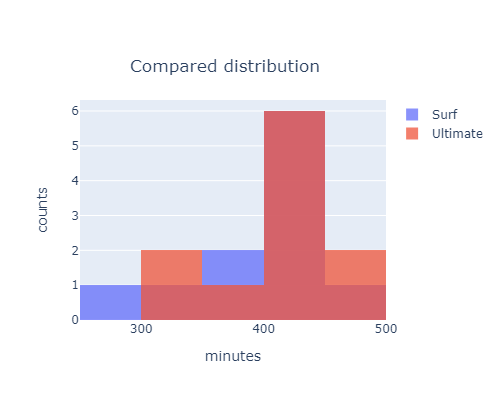

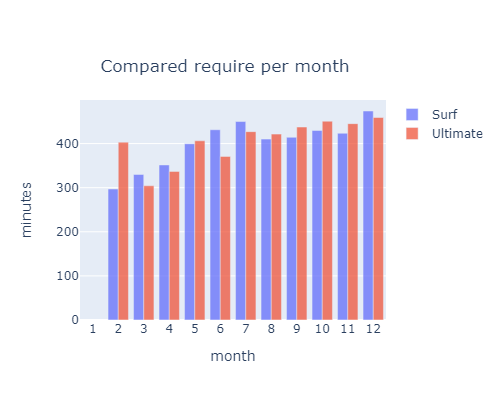

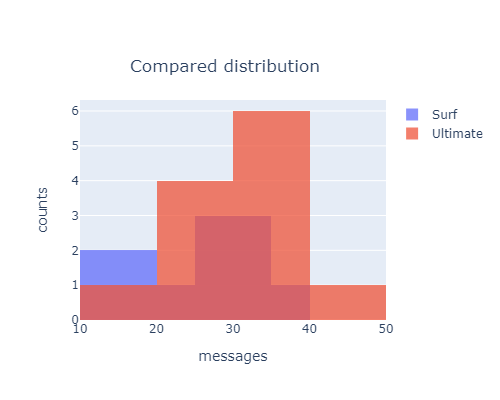

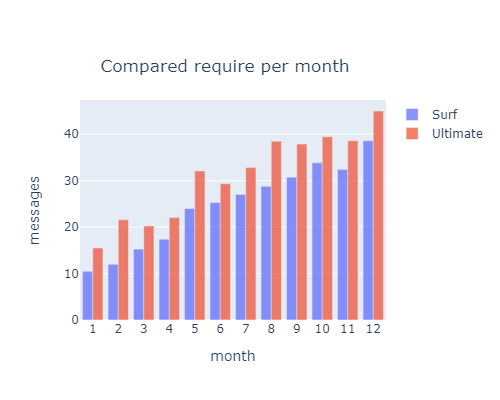

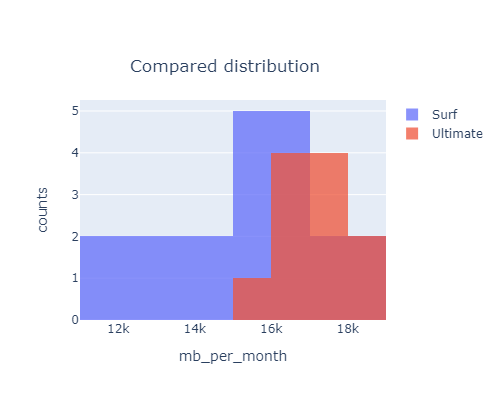

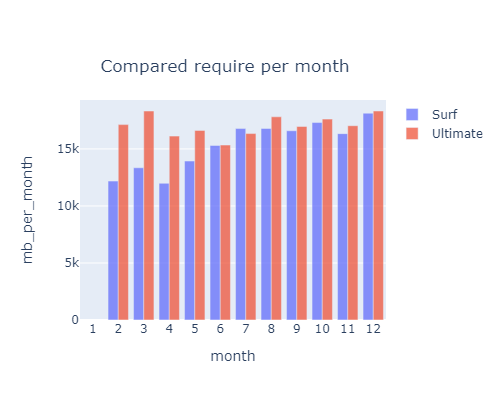

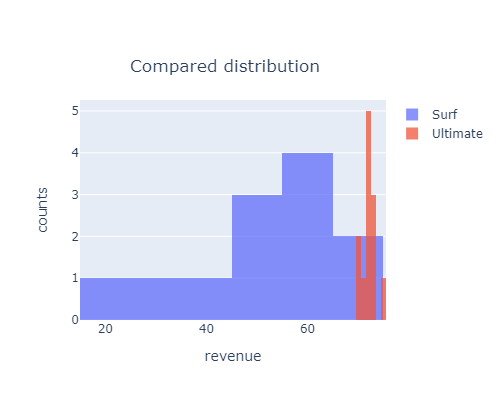

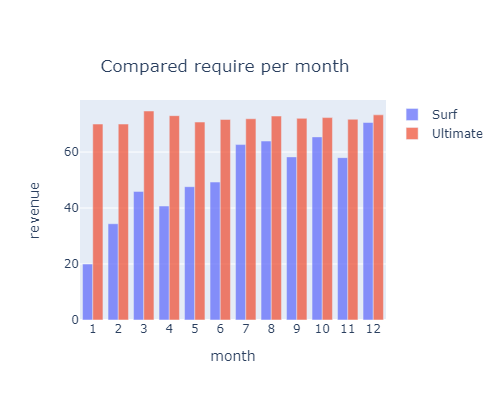

In [25]:
#creat all the deeded graphs
columns = ['minutes','messages','mb_per_month','revenue']
for col_name in columns:
    fig1 = go.Figure()
    fig1.add_trace(go.Histogram(x=clean_surf[col_name], nbinsx = 6, name = 'Surf'))
    fig1.add_trace(go.Histogram(x=clean_ultimate[col_name], name = 'Ultimate'))

    # Overlay both histograms
    fig1.update_layout(barmode='overlay', xaxis_title = col_name, yaxis_title = 'counts',
                       title={'text': 'Compared distribution','y':0.85, 'x':0.45, 'xanchor': 'center'},
                       width = 500, height = 400)
    # Reduce opacity to see both histograms
    fig1.update_traces(opacity=0.75)
    
    fig2 = go.Figure()
    fig2.add_trace(go.Bar(x=clean_surf.index, y = clean_surf[col_name],  name = 'Surf'))
    fig2.add_trace(go.Bar(x=clean_ultimate.index, y = clean_ultimate[col_name], name = 'Ultimate'))

    # Overlay both bar charts
    fig2.update_layout(barmode='group', xaxis_title = 'month', yaxis_title = col_name,
                       xaxis = dict(dtick = 1),
                       title={'text': 'Compared require per month','y':0.85, 'x':0.45, 'xanchor': 'center'},
                       width = 500, height = 400)
    # Reduce opacity to see both bars
    fig2.update_traces(opacity=0.75)
    
    fig1.show("png")
    fig2.show("png")

It seems that in both plans, an avarage customer in an avarage month is calling for about 400-450 minutes, sending 20-40 texts and using 15-17k of mb (14.5-16.5 gb). In most of the parameters we see growth in the 'surf' taarif, and more slight in the 'ultimate' maybe it depends on the amoount on customers in each plan in each month.

## 4. Statistical Data Analysis
<a class="anchor" id="chapter4"></a>

We want to test two hypothesis:
- The average revenue from users of Ultimate and Surf calling plans differs.
- The average revenue from users in NY-NJ area is different from that of the users from other regions.

For te first hypothesis we'll define the null hypothesis and the alternative hepothesis as follow:
- H_0 = mean(Ultimate_revenue) is equal to mean(Surf_revenue)  
- H_a = mean(Ultimate_revenue) is **not** equal to mean(Surf_revenue)  

First we will check if our distribution is normal with Shapiro-Wilk test for normality and than we'll decide which test to choose. The hypothesis for the Shapiro-Wilk are as follow:
- H_0 = the data has a normal distribution
- H_a = the data doesn't have a normal distribution

In [26]:
#check if the distribution is normal
display(st.shapiro(clean_surf['revenue']), st.shapiro(clean_ultimate['revenue']))

ShapiroResult(statistic=0.9433496594429016, pvalue=0.5426446199417114)

ShapiroResult(statistic=0.9618239998817444, pvalue=0.8095207810401917)

The p-value is grater than 0.05 which means that the assumption of **normality was not rejected**, so we will choose the t-test! Now we'll check the varience values for both plans to know how to declare equal_var. The equality will be tested with Levene’s test. The hypothesis for this test are as follow:
- H_0 = the variance values of the two datasets are equal.
- H_a = the variance values of the two datasets are not equal.

In [27]:
#check if the variance values are equal
st.levene(clean_surf['revenue'], clean_ultimate['revenue'], center='mean')

LeveneResult(statistic=20.80436443418562, pvalue=0.0001531925821834029)

The p-values for this test is less than 0.05 thus we reject the null hypothesis and we consider the variance values as not equal.

In [28]:
alpha = 0.05 # critical statistical significance level
#check if the means of the groups are equal
results = st.ttest_ind(clean_surf['revenue'], clean_ultimate['revenue'], equal_var =False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  0.0004970238953490146
We reject the null hypothesis


The null hypothesis was rejected, therefore, we can conclude that the average revenue from users of Ultimate and Surf calling plans differs. We talked about the avarage revenue of an avarage customer. Let's see a boxplot that compares the means (which we clearly see that are differ from each other) and the plans' **total revenue**

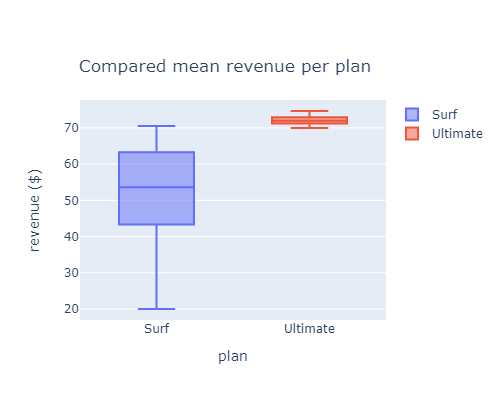

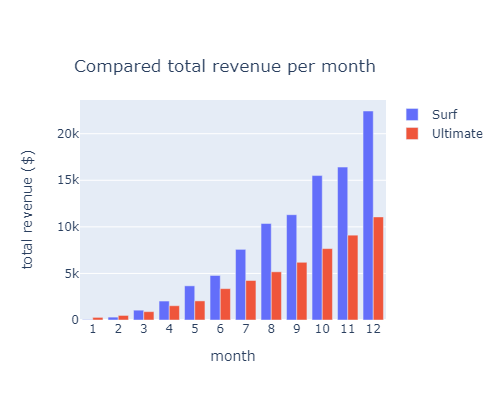

In [29]:
#creat the neede graphs
fig = go.Figure()
fig.add_trace(go.Box(y=clean_surf['revenue'], name = 'Surf'))
fig.add_trace(go.Box(y=clean_ultimate['revenue'], name = 'Ultimate'))
fig.update_layout(xaxis_title = 'plan', yaxis_title = 'revenue ($)',
                  title={'text': 'Compared mean revenue per plan','y':0.85, 'x':0.45,'xanchor': 'center'}
                  , width = 500, height = 400)
fig.show("png")

#creat a pivot table grouped by plan and months - *totals*
total_per_month = (
    user_summary
    .pivot_table(index = ['plan','month'], values = ['minutes','messages','mb_per_month','revenue'], aggfunc = 'sum').reset_index())

fig2 = go.Figure()
fig2.add_trace(go.Bar(x =total_per_month.query('plan == "surf"')['month'],
                     y = total_per_month.query('plan == "surf"')['revenue'],  name = 'Surf'))
fig2.add_trace(go.Bar(x =total_per_month.query('plan == "ultimate"')['month'],
                     y = total_per_month.query('plan == "ultimate"')['revenue'], name = 'Ultimate'))
# Overlay both bar charts
fig2.update_layout(barmode='group', xaxis_title = 'month', yaxis_title = 'total revenue ($)',
                       xaxis = dict(dtick = 1),
                       title={'text': 'Compared total revenue per month','y':0.85, 'x':0.45, 'xanchor': 'center'},
                       width = 500, height = 400)

fig2.show("png")

We can see that maybe an avarage revenue from a customer in the 'Ultimate' taarif is higher than in 'Surf' but when we look at the totals, the customers of the 'Surf' plan are bringing more profit! Probably more people are signed to 'Surf'

For te second hypothesis we'll define the null hypothesis as follow:
- H0 = mean(NY-NJ_revenue) is equal to mean(Other_revenue)
- H_a = mean(NY-NJ_revenue) is **not** equal to mean(Other_revenue) 

First we will check if our distribution is normal with Shapiro-Wilk test as we explained before.

In [30]:
#save the user ids of the people from NY-NJ
users_ny_nj = df_users[df_users.city.str.contains('NY-NJ')][['user_id','city']]
users_ny_nj['city'] = 'NY-NJ'

#add a column to the user summary table that indicates the city
user_summary_NY_others = user_summary.merge(users_ny_nj, on = 'user_id', how = 'left').fillna('Other')
NY_NJ_revenue = user_summary_NY_others.query('city == "NY-NJ"')['revenue']
others_revenue = user_summary_NY_others.query('city == "Other"')['revenue']

In [31]:
#check if the distribution is normal
display(st.shapiro(NY_NJ_revenue), st.shapiro(others_revenue))

ShapiroResult(statistic=0.8283720016479492, pvalue=9.160762912674237e-20)

ShapiroResult(statistic=0.7427323460578918, pvalue=0.0)

The p-value is much less than 0.05 which means that the assumption of **normality *was* rejected**, so we will choose the Mann-Whitney U test that doesn't require a normal distribution.

In [32]:
alpha = 0.05 # critical statistical significance level
#check if the means of the groups are equal
results = st.mannwhitneyu(NY_NJ_revenue, others_revenue)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 
    

p-value:  0.0019638157250138114
We reject the null hypothesis


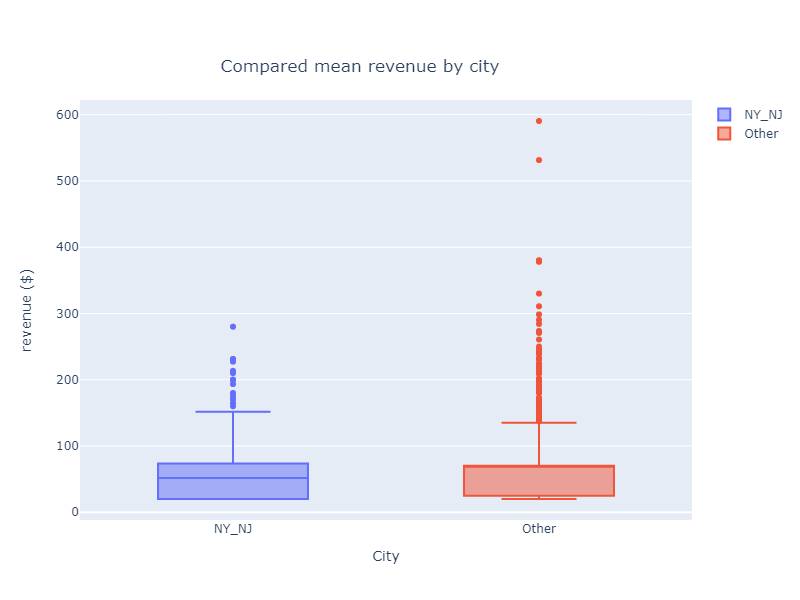

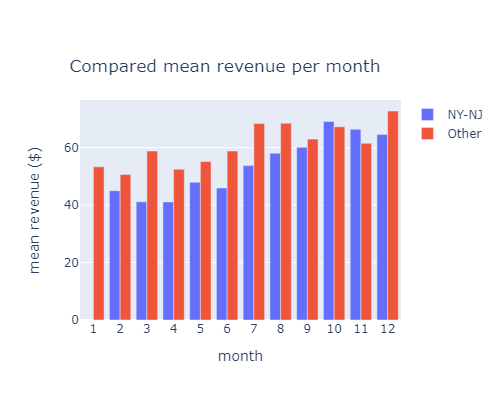

In [33]:
#creat the neede graphs
fig = go.Figure()
fig.add_trace(go.Box(y = NY_NJ_revenue, name = 'NY_NJ'))
fig.add_trace(go.Box(y = others_revenue, name = 'Other'))
fig.update_layout(xaxis_title = 'City', yaxis_title = 'revenue ($)',
                  title={'text': 'Compared mean revenue by city','y':0.9, 'x':0.45,'xanchor': 'center'}
                  , width = 800, height = 600)
fig.show("png")

#creat a pivot table grouped by city and months - *totals*
mean_city_per_month = (
    user_summary_NY_others
    .pivot_table(index = ['city','month'], values = ['minutes','messages','mb_per_month','revenue']).reset_index())

fig2 = go.Figure()
fig2.add_trace(go.Bar(x =mean_city_per_month.query('city == "NY-NJ"')['month'],
                     y = mean_city_per_month.query('city == "NY-NJ"')['revenue'],  name = 'NY-NJ'))
fig2.add_trace(go.Bar(x =mean_city_per_month.query('city == "Other"')['month'],
                     y = mean_city_per_month.query('city == "Other"')['revenue'], name = 'Other'))
# Overlay both bar charts
fig2.update_layout(barmode='group', xaxis_title = 'month', yaxis_title = 'mean revenue ($)',
                       xaxis = dict(dtick = 1),
                       title={'text': 'Compared mean revenue per month','y':0.85, 'x':0.45, 'xanchor': 'center'},
                       width = 500, height = 400)

fig2.show("png")

The null hypothesis was rejected, therefore, we can conclude that the average revenue from users in NY-NJ area is different from that of the users from other regions! We checked it and found that the mean revenue from people in NY-NJ is lower than in other cities! Intersting why? We should investigate their behviour in the future

## 5. Overall conclusion
<a class="anchor" id="chapter5"></a>

In this study, we analayzed collected data about the usage of 500 clients of Mgaline. The aim of this research was to test which of the two plans that we offer is more profitable for the company.

The quality of the data was good enough for our research. We found one column with missing values, the `churn_date` column but it has a meaning - the missing values were for users that are still using our services when this data was gathered. We also found out that 20% of the calls are of 0 duration, it makes sense that 1 of 5 calls is not answerd but we also found that 1 out of 8 internet session (~13%) is saved as 0 MB. We need to figure out why exactly we recieve these numbers, if it caused by our infrastructures we should think how to improve it.

It seems that in both plans, an avarage customer in an avarage month is calling for about 400-450 minutes, sending 20-40 texts and using 15-17k of mb (14.5-16.5 gb). So in most of the parameters the 'Surf' taarif is enough, but still there are people that exceeds the limitations and pay a little more. It's much more common to pay extra fee in the 'Surf' taarif than in the 'Ultimate' and that's why an avarage customer of the 'Ultimate' plan is more profitable but in totals the 'Surf' plan brings more money to the company.  
People preffer to pay less so it seems that the 'Surf' plan will be popular even without massive advertising and we should keep the limits unchanged beacuse it is easy to exceed those limits and pay the extra fee which bring us more revenue.
The usage of an avarage customer is pretty much the same on both plans and probably won't exceed the 'Ultimate' limits, so the profit per customer in this plan is higher and we want more people to join this plan.  
In addition, we found out that the revenue of people from NY-NJ differ from people in other places, and it is lower then other cities, so it will be better to investigate why.